<a href="https://colab.research.google.com/github/PSXBRosa/CatsVSDogs/blob/master/CV1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [0]:
TRAIN_DATA = tfds.load('cats_vs_dogs', split='train')
SIZE = 100

def build_network():
    '''creates a cnn, with five convolutional layers and two
    dense layers, the last one beeing an output layer.'''
    model = Sequential()
    model.add(Input(shape=(SIZE,SIZE,1)))
    ## Some VGGs

    model.add(Conv2D(64, 3, activation = 'relu', padding='same'))
    model.add(MaxPool2D(3))

    model.add(Conv2D(128, 3, activation = 'relu', padding='same'))
    model.add(MaxPool2D(3))
    model.add(Dropout(.35))

    model.add(Conv2D(64, 3, activation = 'relu', padding='same'))
    model.add(MaxPool2D(3))

    model.add(Conv2D(128, 3, activation = 'relu', padding='same'))
    model.add(MaxPool2D(3))

    model.add(Conv2D(1024, 3, activation = 'relu', padding='same'))
    model.add(Dropout(.35))

    ## Plus some FCLs 
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'Adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    return model

def treat(image, size):
    '''resizes and recolors the image'''
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    img = cv2.resize(img, (size,size))
    return img

23262it [00:30, 769.16it/s]


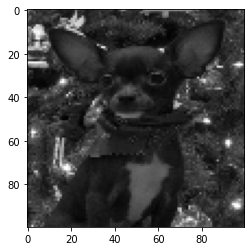

In [4]:
TRAIN=[]
TEST=[]

counter = 0
for each in tqdm(tfds.as_numpy(TRAIN_DATA), ncols=1000, ascii=True):
    # creating the dataset
    image, label = each['image'], each['label']
    image = treat(image, SIZE)
    if counter%10 == 0: TEST.append((image,label))
    else: TRAIN.append((image,label))
    counter = (counter + 1)%10

plt.imshow(TRAIN[0][0],cmap='gray')
plt.show()

In [5]:
np.random.shuffle(TRAIN)
np.random.shuffle(TEST)

X = np.array([i[0] for i in TRAIN]).reshape(-1,SIZE,SIZE,1)
Y = np.array([i[1] for i in TRAIN])
T_X = np.array([j[0] for j in TEST]).reshape(-1,SIZE,SIZE,1)
T_Y = np.array([j[1] for j in TEST])
model = build_network()
print(model.summary())
print(len(X),len(Y))
print(len(T_X),len(T_Y))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [6]:
model.fit(X,Y, epochs=20, validation_data=(T_X,T_Y))

Epoch 1/20
655/655 [==============================] - 7s 10ms/step - loss: 0.7067 - accuracy: 0.5370 - val_loss: 0.6879 - val_accuracy: 0.5642
Epoch 2/20
655/655 [==============================] - 6s 10ms/step - loss: 0.6151 - accuracy: 0.6594 - val_loss: 0.5527 - val_accuracy: 0.7164
Epoch 3/20
655/655 [==============================] - 6s 10ms/step - loss: 0.5313 - accuracy: 0.7361 - val_loss: 0.5013 - val_accuracy: 0.7512
Epoch 4/20
655/655 [==============================] - 6s 10ms/step - loss: 0.4608 - accuracy: 0.7833 - val_loss: 0.4088 - val_accuracy: 0.8066
Epoch 5/20
655/655 [==============================] - 7s 10ms/step - loss: 0.4096 - accuracy: 0.8132 - val_loss: 0.3968 - val_accuracy: 0.8139
Epoch 6/20
655/655 [==============================] - 7s 10ms/step - loss: 0.3805 - accuracy: 0.8284 - val_loss: 0.3481 - val_accuracy: 0.8436
Epoch 7/20
655/655 [==============================] - 6s 10ms/step - loss: 0.3537 - accuracy: 0.8455 - val_loss: 0.3516 - val_accuracy: 0.8414

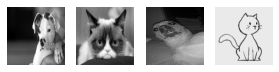

the 1° image was identified as a dog, certainty: 0.9993433356285095
the 2° image was identified as a cat, certainty: 0.9997543559293263
the 3° image was identified as a cat, certainty: 0.9883242202922702
the 4° image was identified as a dog, certainty: 0.958961546421051


In [7]:
images = ['filhote-cachorro.jpg', 'cat.jpg', 'dog2.jpg', 'cat2.jpg']
res = lambda x: treat(cv2.imread(x),SIZE)

images_b = list(map(res, images))

for i in range(len(images_b)): 
  plt.subplot(1,len(images_b)+1,i+1)
  plt.imshow(images_b[i],cmap="gray")
  plt.axis('off')
plt.show()

predict = lambda x: model.predict(np.array(x).reshape(-1,SIZE,SIZE,1))[0][0]
predictions = list(map(predict, images_b))

look_up_table = {0: 'cat', 1: 'dog'}

for i in range(len(predictions)):
    print(f'the {i+1}° image was identified as a {look_up_table[round(predictions[i])]}, certainty: {max(predictions[i], 1-predictions[i])}')

How you can see, images that could properly fit the dataset are easily correctly classified. However, some more peculiar pictures, such joke images or drawings are not well classified.